# Phase 1-1: Member County Activity

* Purpose: This file attempts to aggregate member's account data based on their counties and classify them into distinct activity groups.

## Importing Packages and Data

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler # MinMaxScaler affected by outliers
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
member_level_df = pd.read_csv('data/Member_Level_Dataset.csv')
member_level_df.head()

,Unique_Member_Identifier,EOM_TRANS_DATE,age,BranchCategory,address_zip,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,...,ATMCount,BillPaymentCount,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount
0,360faa7e8e345d2725f92460ca39696ad885b876805328...,2022-01-31,85,Winter Garden,34760,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4ef271022b929dd2ea56f3c0e9a7efae346a07e40f6ea1...,2022-01-31,59,Lake Nona,34771,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,f868c8fb32d526c00024e408fdd712e881de936372bef8...,2022-01-31,38,MetroWest,32765,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4fe6ec028a8a5234bb02fbe97488fb9431109a292ee8bc...,2022-01-31,67,Kissimmee,34744,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,f46df5083939ce116be51669af3315c474655c936204c2...,2022-01-31,47,East Orlando,32825,3,2,1,0,0,...,0,0,0,0,0,1,2,2,0,1


In [ ]:
# Map BranchCategory to County
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}


## Data Preprocessing

In [ ]:
# Remove member identifiers
member_level_df = member_level_df.drop(columns=['Unique_Member_Identifier'])

In [ ]:
# Remove the rows that contains 'Virtual Branch' in the 'BranchCategory' column
no_virtual_df = member_level_df[member_level_df['BranchCategory'] != 'Virtual Branch']

In [ ]:
# Remove the rows that contains 'High School' in the name in 'BranchCategory' column
no_highschool_df = no_virtual_df[~member_level_df['BranchCategory'].str.contains('High School')]

C:\Users\perez\AppData\Local\Temp\ipykernel_26204\2725168190.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
# Drop empty rows
no_highschool_df = no_highschool_df.dropna()

In [ ]:
# numerical columns
numerical_df = no_highschool_df.select_dtypes(include=['int64', 'float64'])

vif_data = pd.DataFrame()
vif_data["Variable"] = numerical_df.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) for i in range(numerical_df.shape[1])]
print(vif_data)

c:\Users\perez\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning:

divide by zero encountered in scalar divide



               Variable       VIF
0                   age  4.469401
1               n_accts       inf
2      n_checking_accts       inf
3       n_savings_accts       inf
4          n_open_loans  1.956129
5            n_open_cds       inf
6     n_open_club_accts       inf
7   n_open_credit_cards  1.823530
8              ATMCount  1.087761
9      BillPaymentCount  1.066652
10            CashCount  1.018235
11           DraftCount  1.165459
12             ACHCount  1.226394
13             FeeCount  1.232675
14    Credit_DebitCount  1.267735
15         Home_Banking  1.089248
16            WireCount  1.003263
17        DividendCount  4.249345


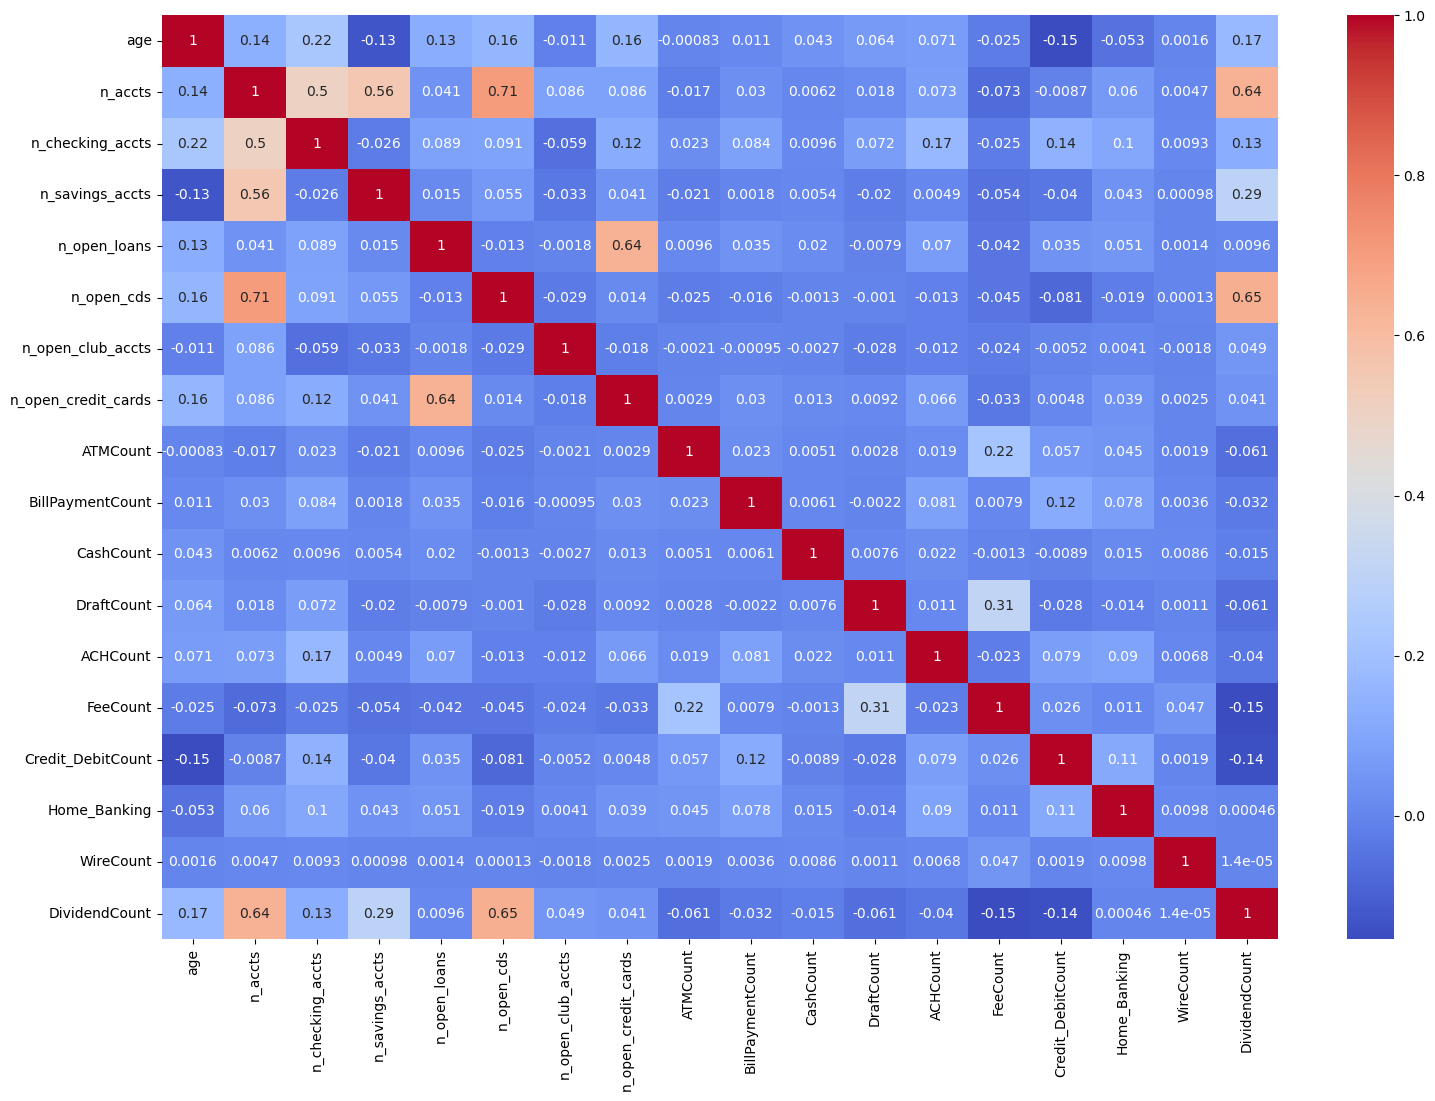

In [ ]:
# Plot correlation matrix
corr = numerical_df.corr()
plt.figure(figsize=(18, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Displays the number of unique values for each column
numerical_df.nunique().sort_values(ascending=False)

age                    109
DividendCount           46
Credit_DebitCount       40
Home_Banking            40
ACHCount                34
n_accts                 29
n_open_cds              27
BillPaymentCount        24
FeeCount                17
n_savings_accts         15
DraftCount              13
ATMCount                12
CashCount                9
n_checking_accts         8
n_open_loans             5
WireCount                4
n_open_club_accts        3
n_open_credit_cards      2
dtype: int64

In [ ]:
county_df = no_highschool_df.copy()

county_df['County'] = county_df['BranchCategory'].map(city_to_county_mapping)

# Load revenue data
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only 'County' and 'TOTAL - All Revenue Account Codes' columns
df_revenue = df_revenue.iloc[:, [0, -3]]
df_revenue.columns = ['County', 'Revenue_Per_County']
df_revenue = df_revenue.drop(0)

# Merging the DataFrames
county_df = pd.merge(county_df, df_revenue, on='County', how='left')

# Displaying the combined DataFrame
county_df.head()

,EOM_TRANS_DATE,age,BranchCategory,address_zip,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,n_open_club_accts,...,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount,County,Revenue_Per_County
0,2022-01-31,85,Winter Garden,34760,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,Orange,6968835122
1,2022-01-31,59,Lake Nona,34771,2,1,1,0,0,0,...,0,0,0,0,0,0,0,1,Orange,6968835122
2,2022-01-31,38,MetroWest,32765,2,0,1,0,0,1,...,0,0,0,0,0,0,0,1,Orange,6968835122
3,2022-01-31,67,Kissimmee,34744,1,0,1,1,0,0,...,0,0,0,0,0,0,0,1,Osceola,1592120547
4,2022-01-31,47,East Orlando,32825,3,2,1,0,0,0,...,0,0,0,1,2,2,0,1,Orange,6968835122


In [ ]:
# Assuming 'BranchCategory' uniquely identifies each branch
branch_count = county_df.groupby('County')['BranchCategory'].nunique()
branch_count.name = 'Branch_Count'

# Aggregate the member activity data by the 'County' column, summing up all the activity-related columns
county_activity_agg = county_df.groupby('County').agg({
    'DividendCount': 'sum',
    'Home_Banking': 'sum',
    'Credit_DebitCount': 'sum',
    'ACHCount': 'sum',
    'n_accts': 'sum',
    'n_open_cds': 'sum',
    'BillPaymentCount': 'sum',
    'FeeCount': 'sum',
    'n_savings_accts': 'sum',
    'DraftCount': 'sum',
    'ATMCount': 'sum',
    'CashCount': 'sum',
    'n_checking_accts': 'sum',
    'n_open_loans': 'sum',
    'WireCount': 'sum',
    'n_open_club_accts': 'sum',
    'n_open_credit_cards': 'sum'
}).reset_index()

# Calculate the total Activity per county
county_activity_agg['Total_Activity'] = county_activity_agg.drop('County', axis=1).sum(axis=1)

# Calculate the average Activity per branch for each county
county_activity_agg = county_activity_agg.merge(branch_count.reset_index(), on='County')
county_activity_agg['Average_Activity_Per_Branch'] = county_activity_agg['Total_Activity'] / county_activity_agg['Branch_Count']

# Display the DataFrame with total and average Activity
county_activity_agg[['County', 'Total_Activity', 'Branch_Count', 'Average_Activity_Per_Branch']]

,County,Total_Activity,Branch_Count,Average_Activity_Per_Branch
0,Brevard,94796,1,94796.000000
1,Lake,1110490,3,370163.333333
2,Orange,5820144,10,582014.400000
3,Osceola,2087538,3,695846.000000
4,Polk,264614,1,264614.000000
5,Seminole,2510613,7,358659.000000
6,Volusia,305654,1,305654.000000


     County  Total_Activity  Branch_Count  Average_Activity_Per_Branch
3   Osceola         2087538             3                695846.000000
2    Orange         5820144            10                582014.400000
1      Lake         1110490             3                370163.333333
5  Seminole         2510613             7                358659.000000
6   Volusia          305654             1                305654.000000
4      Polk          264614             1                264614.000000
0   Brevard           94796             1                 94796.000000


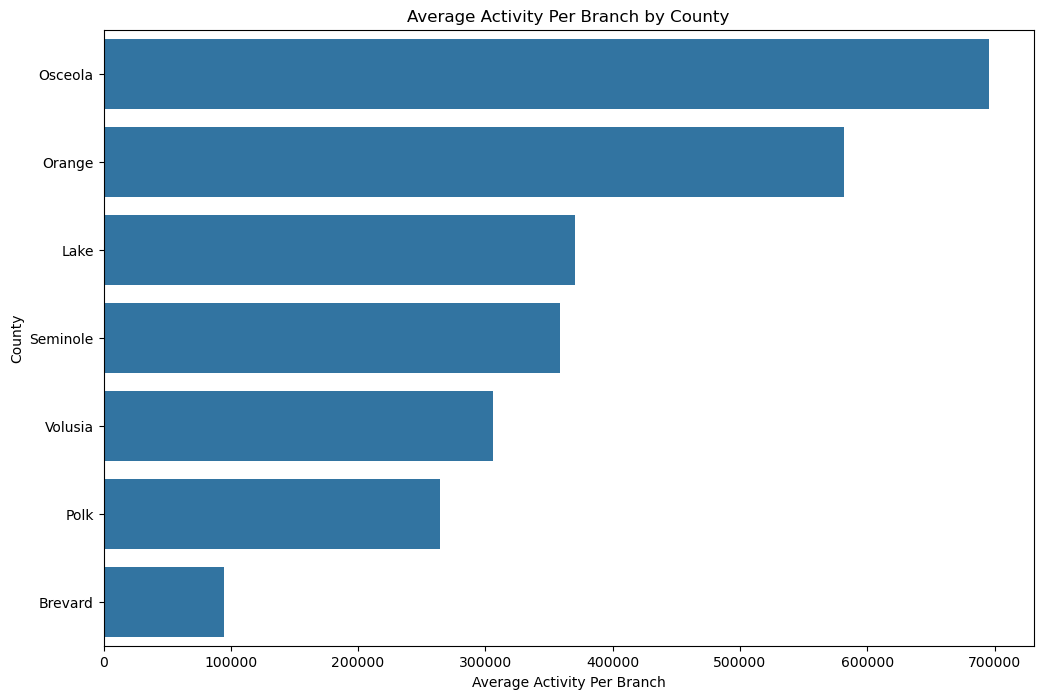

In [ ]:
# Sorting counties by the average transactions per branch
county_activity_agg_sorted = county_activity_agg.sort_values(by='Average_Activity_Per_Branch', ascending=False)

# Displaying the counties with their average transaction data per branch
print(county_activity_agg_sorted[['County', 'Total_Activity', 'Branch_Count', 'Average_Activity_Per_Branch']])

# Visualization - Average Activity per Branch by County
plt.figure(figsize=(12, 8))
sns.barplot(y=county_activity_agg_sorted['County'], x=county_activity_agg_sorted['Average_Activity_Per_Branch'], )
plt.title('Average Activity Per Branch by County')
plt.ylabel('County')
plt.xlabel('Average Activity Per Branch')
plt.show()

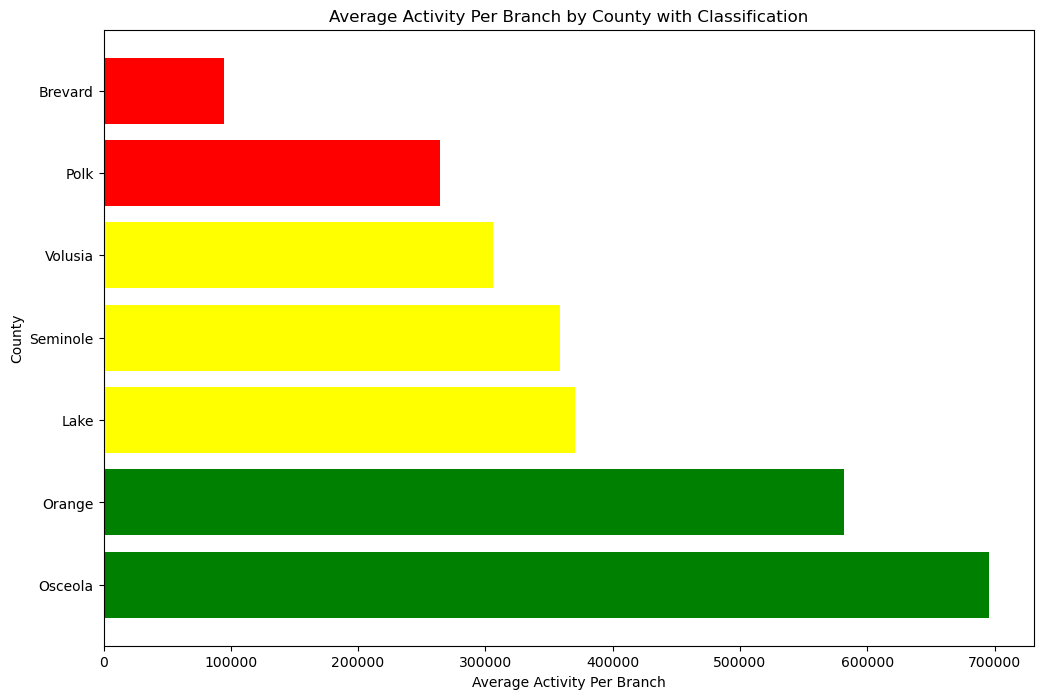

In [ ]:
# Define classification thresholds
high_threshold = county_activity_agg_sorted['Average_Activity_Per_Branch'].quantile(0.75) # top 25%
medium_threshold = county_activity_agg_sorted['Average_Activity_Per_Branch'].quantile(0.25) # bottom 25%

# Classify counties
county_activity_agg_sorted['Classification'] = 'Low'
county_activity_agg_sorted.loc[county_activity_agg_sorted['Average_Activity_Per_Branch'] >= medium_threshold, 'Classification'] = 'Medium'
county_activity_agg_sorted.loc[county_activity_agg_sorted['Average_Activity_Per_Branch'] >= high_threshold, 'Classification'] = 'High'

# Visualize the classified data
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}
plt.figure(figsize=(12, 8))
plt.barh(county_activity_agg_sorted['County'], county_activity_agg_sorted['Average_Activity_Per_Branch'], color=[colors[cls] for cls in county_activity_agg_sorted['Classification']])
plt.title('Average Activity Per Branch by County with Classification')
plt.xlabel('Average Activity Per Branch')
plt.ylabel('County')
plt.show()


# Phase 1-2: Member County PCA

*   Purpose: This file attempts to view if any pattern emerged from PCA analysis and county groupings

## Data Preprocessing

In [ ]:
# Remove the rows that contains 'Virtual Branch' in the 'BranchCategory' column
no_virtual_df = member_level_df[member_level_df['BranchCategory'] != 'Virtual Branch']

In [ ]:
# Remove the rows that contains 'High School' in the name in 'BranchCategory' column
no_highschool_df = no_virtual_df[~member_level_df['BranchCategory'].str.contains('High School')]

C:\Users\perez\AppData\Local\Temp\ipykernel_26204\2725168190.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
# Drop empty rows
no_highschool_df = no_highschool_df.dropna()

In [ ]:
# Mapping dictionary with proper case
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

county_df = no_highschool_df.copy()

# Add a 'County' column based on the 'BranchCategory' column
county_df['County'] = county_df['BranchCategory'].map(city_to_county_mapping)

# Identify any rows where the county couldn't be mapped
unmapped_rows = county_df[county_df['County'].isnull()]
print(unmapped_rows)

Empty DataFrame
Columns: [EOM_TRANS_DATE, age, BranchCategory, address_zip, n_accts, n_checking_accts, n_savings_accts, n_open_loans, n_open_cds, n_open_club_accts, n_open_credit_cards, ATMCount, BillPaymentCount, CashCount, DraftCount, ACHCount, FeeCount, Credit_DebitCount, Home_Banking, WireCount, DividendCount, County]
Index: []

[0 rows x 22 columns]


Attempting to cluster the different counties and view what pattern emerges.

In [ ]:
# Drop unnecessary columns
data_for_clustering = county_df.drop(['EOM_TRANS_DATE', 'BranchCategory', 'address_zip', 'County'], axis=1)
data_for_clustering.head()

,age,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,n_open_club_accts,n_open_credit_cards,ATMCount,BillPaymentCount,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount
0,85,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,59,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,38,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,67,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,47,3,2,1,0,0,0,0,0,0,0,0,0,1,2,2,0,1


In [ ]:
scaler = StandardScaler()
normalized_df = scaler.fit_transform(data_for_clustering)
normalized_df = pd.DataFrame(normalized_df, columns=data_for_clustering.columns)
# normalized_df.columns = [col + '_norm' for col in normalized_df.columns]
normalized_df.index = data_for_clustering.index
normalized_df.head()

,age,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,n_open_club_accts,n_open_credit_cards,ATMCount,BillPaymentCount,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount
0,1.727636,-1.153673,-1.515371,-0.454164,-0.396081,-0.261204,-0.205127,-0.275022,-0.157307,-0.194599,-0.119586,-0.17688,-0.405615,-0.193520,-0.438801,-0.219496,-0.018926,-0.046666
1,0.453627,-0.396488,0.097839,-0.454164,-0.396081,-0.261204,-0.205127,-0.275022,-0.157307,-0.194599,-0.119586,-0.17688,-0.405615,-0.193520,-0.438801,-0.219496,-0.018926,-0.046666
2,-0.575380,-0.396488,-1.515371,-0.454164,-0.396081,-0.261204,4.843145,-0.275022,-0.157307,-0.194599,-0.119586,-0.17688,-0.405615,-0.193520,-0.438801,-0.219496,-0.018926,-0.046666
3,0.845630,-1.153673,-1.515371,-0.454164,1.843818,-0.261204,-0.205127,-0.275022,-0.157307,-0.194599,-0.119586,-0.17688,-0.405615,-0.193520,-0.438801,-0.219496,-0.018926,-0.046666
4,-0.134377,0.360698,1.711049,-0.454164,-0.396081,-0.261204,-0.205127,-0.275022,-0.157307,-0.194599,-0.119586,-0.17688,-0.405615,3.740215,1.375045,2.763451,-0.018926,-0.046666


## PCA Analysis

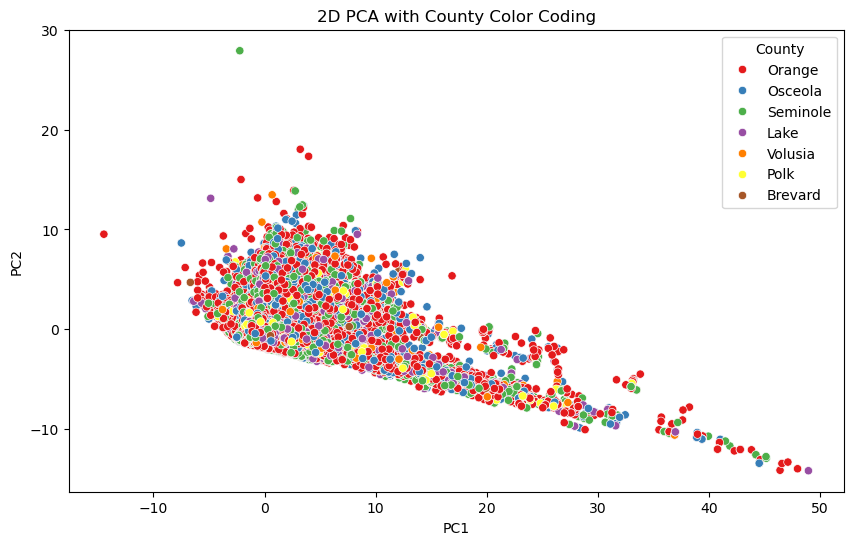

In [ ]:
# Apply 2D PCA
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(normalized_df)

# Create a DataFrame for 2D PCA results
pca_df_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'])
pca_df_2d['County'] = county_df['County']

# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='County', data=pca_df_2d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

In [ ]:
# Get the feature loadings for PC1 and PC2
loadings_df = pd.DataFrame(pca_2d.components_, columns=normalized_df.columns, index=['PC1', 'PC2'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

Feature Loadings for PC1:
n_accts                0.569494
DividendCount          0.488457
n_open_cds             0.461678
n_savings_accts        0.275346
n_checking_accts       0.263851
age                    0.178307
n_open_credit_cards    0.124917
n_open_loans           0.093140
ACHCount               0.051555
Home_Banking           0.035666
n_open_club_accts      0.018766
BillPaymentCount       0.013466
CashCount              0.007392
WireCount              0.002040
DraftCount            -0.015192
ATMCount              -0.044065
Credit_DebitCount     -0.061261
FeeCount              -0.109484
Name: PC1, dtype: float64

Feature Loadings for PC2:
n_open_loans           0.569492
n_open_credit_cards    0.565014
n_checking_accts       0.274314
ACHCount               0.237108
age                    0.214644
Credit_DebitCount      0.169127
BillPaymentCount       0.155429
Home_Banking           0.155303
ATMCount               0.083952
DraftCount             0.076324
CashCount              0.

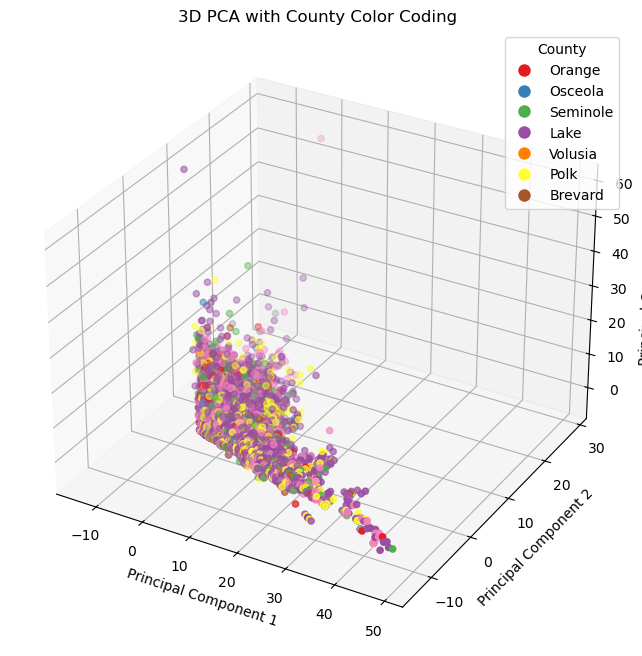

In [ ]:
# Apply 3D PCA
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(normalized_df)

# Create a DataFrame for 3D PCA results
pca_df_3d = pd.DataFrame(data=pca_result_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['County'] = county_df['County']

# Plot 3D PCA
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter_3d = ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'], c=pca_df_3d['County'].astype('category').cat.codes, cmap='Set1')

# Create a legend
legend_labels = county_df['County'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sns.color_palette('Set1')[i], markersize=10, label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, title='County', loc='upper right')

ax.set_title('3D PCA with County Color Coding')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

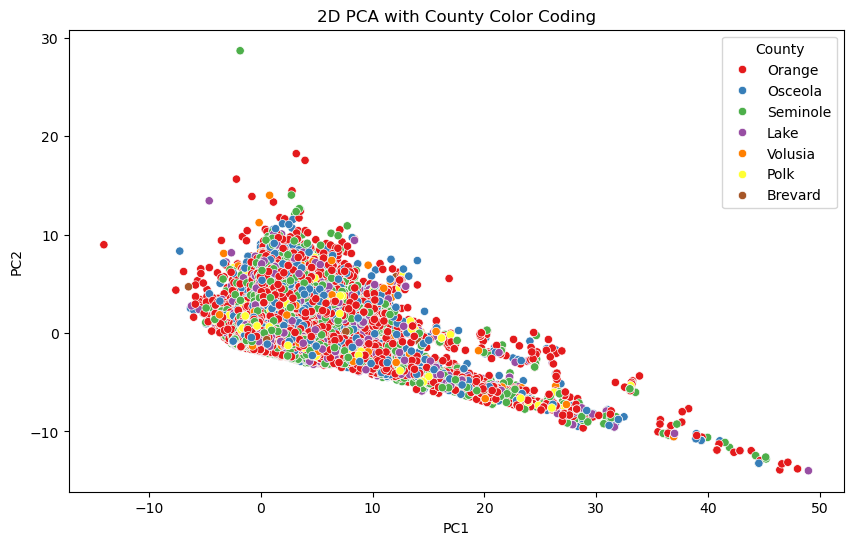

In [ ]:
# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='County', data=pca_df_3d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

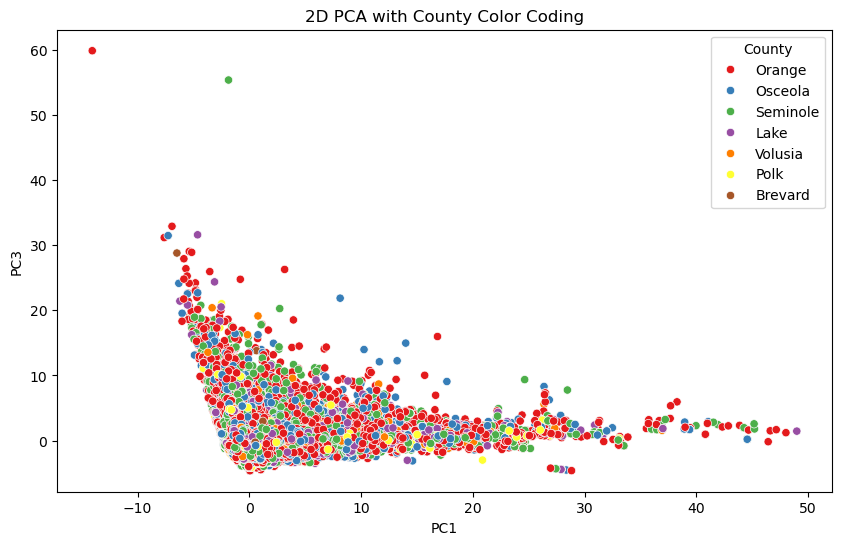

In [ ]:
# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC3', hue='County', data=pca_df_3d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

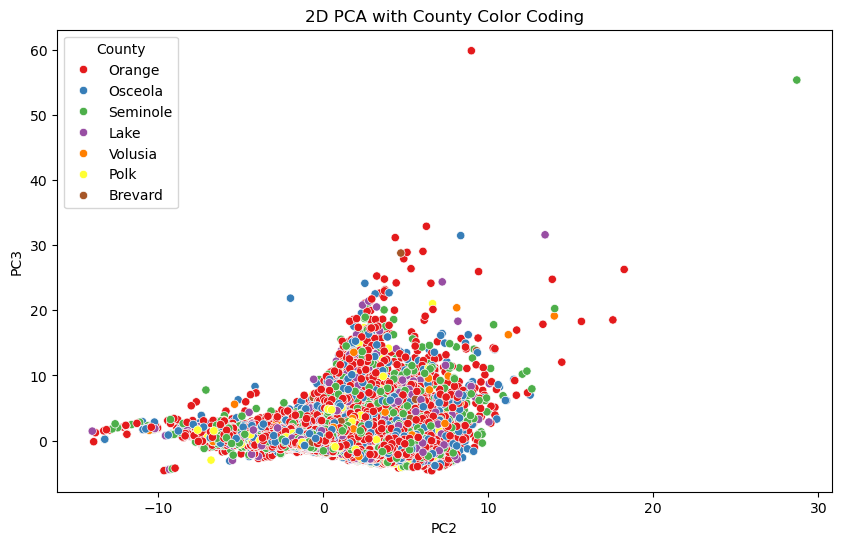

In [ ]:
# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC2', y='PC3', hue='County', data=pca_df_3d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

In [ ]:
# Get the feature loadings for PC1, PC2, and PC3
loadings_df = pd.DataFrame(pca_3d.components_, columns=normalized_df.columns, index=['PC1', 'PC2', 'PC3'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

print("\nFeature Loadings for PC3:")
print(loadings_df.loc['PC3'].sort_values(ascending=False))

Feature Loadings for PC1:
n_accts                0.569536
DividendCount          0.488541
n_open_cds             0.462019
n_savings_accts        0.275226
n_checking_accts       0.263394
age                    0.177779
n_open_credit_cards    0.125163
n_open_loans           0.093361
ACHCount               0.052344
Home_Banking           0.035560
n_open_club_accts      0.019463
BillPaymentCount       0.013935
CashCount              0.007414
WireCount              0.000879
DraftCount            -0.016305
ATMCount              -0.043393
Credit_DebitCount     -0.061962
FeeCount              -0.108443
Name: PC1, dtype: float64

Feature Loadings for PC2:
n_open_loans           0.570035
n_open_credit_cards    0.565430
n_checking_accts       0.262953
ACHCount               0.242104
age                    0.219431
Credit_DebitCount      0.171715
BillPaymentCount       0.159070
Home_Banking           0.155842
ATMCount               0.087924
DraftCount             0.079673
CashCount              0.

# Phase 1-3: Branch County PCA

*	EDA: Explore multicollinearity using variance inflation factors, pinpoint heteroscedasticity, and delineate variable relationships.

## Import Packages and Data

In [ ]:
branch_level_data = pd.read_csv('data/Branch_Level_Dataset.csv')
branch_level_data.head(5)

,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend
0,2022-01-31,Addition Financial Arena,0,3,0,28,5,20,6,4,14
1,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650
2,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731
3,2022-01-31,Boone High School,1,10,2,8,30,9,80,21,59
4,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551


In [ ]:
# print unique values for BranchCategory and their counts
print(branch_level_data['BranchCategory'].value_counts())

BranchCategory
MetroWest                    19
Sanford                      19
Oak Ridge High School        19
Ocoee High School            19
Orange City                  19
Oviedo                       19
Pine Hills                   19
Poinciana                    19
Poinciana High School        19
Seminole State               19
Altamonte Springs            19
South Orlando                19
St. Cloud                    19
St. Cloud High School        19
The Loop                     19
Timber Creek High School     19
UCF Campus                   19
Virtual Branch               19
Mills                        19
Winter Garden                19
Merritt Island               19
Longwood                     19
Apopka                       19
Boone High School            19
Clermont                     19
Colonial High School         19
Downtown Campus              19
East Orlando                 19
Edgewater High School        19
Eustis                       19
Fern Park                

## Data Preprocessing

In [ ]:
# Remove rows where BranchCategory is 'High School' or 'Virtual Branch'
branch_level_data = branch_level_data[~branch_level_data['BranchCategory'].str.contains("High School|Virtual Branch")]

# Check for null values in the DataFrame
null_values = branch_level_data.isnull().sum()

# Displaying the DataFrame and the null values information
print(branch_level_data.head())
print(null_values)


  EOM_TRANS_DATE            BranchCategory  ATM  Bill Payment  Cash  Draft  \
0     2022-01-31  Addition Financial Arena    0             3     0     28   
1     2022-01-31         Altamonte Springs   98           394    64    469   
2     2022-01-31                    Apopka  198           540   132    705   
4     2022-01-31                  Clermont  143           482   103    499   
6     2022-01-31           Downtown Campus   27            35    12     62   

    ACH  Fee  Credit/Debit Card  Home Banking  Dividend  
0     5   20                  6             4        14  
1  1589  416               1642           646      3650  
2  2219  560               1983           724      5731  
4  1940  539               1834           580      4551  
6   134   78                227            47       275  
EOM_TRANS_DATE       0
BranchCategory       0
ATM                  0
Bill Payment         0
Cash                 0
Draft                0
ACH                  0
Fee                  0

In [ ]:
# Load the Excel file
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only the 'County' and 'TOTAL - All Revenue Account Codes' columns
# Assuming these are the first and the third-last columns in your DataFrame
df_revenue = df_revenue.iloc[:, [0, -3]]

# Renaming the columns for clarity
df_revenue.columns = ['County', 'Revenue_Per_County']

# Dropping the first row if it contains headers from the original table
df_revenue = df_revenue.drop(0)

# Displaying the modified DataFrame
print(df_revenue.head())



     County Revenue_Per_County
1   Alachua         1082349199
2     Baker           89157684
3       Bay         1193216378
4  Bradford           85933027
5   Brevard          958971976


In [ ]:
# Map BranchCategory to County
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

branch_level_data['County'] = branch_level_data['BranchCategory'].map(city_to_county_mapping)

# Load revenue data
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only 'County' and 'TOTAL - All Revenue Account Codes' columns
df_revenue = df_revenue.iloc[:, [0, -3]]
df_revenue.columns = ['County', 'Revenue_Per_County']
df_revenue = df_revenue.drop(0)

# Merging the DataFrames
branch_level_data = pd.merge(branch_level_data, df_revenue, on='County', how='left')

# Displaying the combined DataFrame
branch_level_data.head()


,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend,County,Revenue_Per_County
0,2022-01-31,Addition Financial Arena,0,3,0,28,5,20,6,4,14,Orange,6968835122
1,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650,Seminole,1830400546
2,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731,Orange,6968835122
3,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551,Lake,1003940427
4,2022-01-31,Downtown Campus,27,35,12,62,134,78,227,47,275,Orange,6968835122


In [ ]:
# Dropping unnecessary columns
pre_normalized_df = branch_level_data.drop(['EOM_TRANS_DATE', 'BranchCategory', 'County', 'Revenue_Per_County'], axis=1)
pre_normalized_df.head()

,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend
0,0,3,0,28,5,20,6,4,14
1,98,394,64,469,1589,416,1642,646,3650
2,198,540,132,705,2219,560,1983,724,5731
3,143,482,103,499,1940,539,1834,580,4551
4,27,35,12,62,134,78,227,47,275


In [ ]:
# Fit the data on the scaler object
normalized_df = scaler.fit_transform(pre_normalized_df)

# Convert the normalized DataFrame into a DataFrame
normalized_df = pd.DataFrame(normalized_df, columns=pre_normalized_df.columns)
# normalized_df.columns = [col + '_norm' for col in normalized_df.columns]
normalized_df.head()

,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend
0,-1.449119,-0.617278,-1.138159,-1.348628,-1.026666,-1.596365,-1.436047,-1.445617,-1.484872
1,-0.279600,0.138588,0.004137,0.433753,0.592510,0.099428,-0.040356,0.380911,0.030027
2,0.913787,0.420829,1.217827,1.387589,1.236501,0.716080,0.250555,0.602826,0.897052
3,0.257424,0.308706,0.700224,0.555003,0.951305,0.626152,0.123441,0.193137,0.405418
4,-1.126905,-0.555417,-0.923979,-1.211211,-0.894802,-1.347991,-1.247509,-1.323280,-1.376130


## PCA Analysis

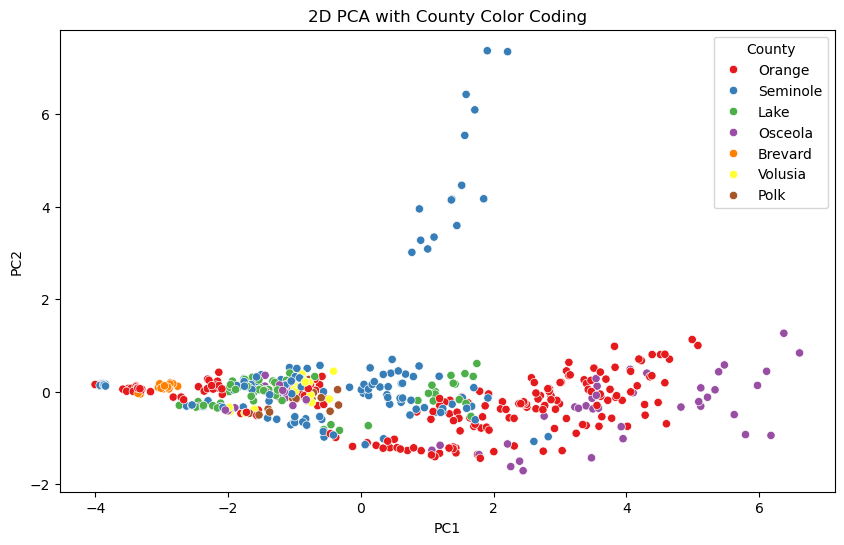

In [ ]:
# Apply 2D PCA
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(normalized_df)

# Create a DataFrame for 2D PCA results
pca_df_2d = pd.DataFrame(data=pca_result_2d, columns=['PC1', 'PC2'])
pca_df_2d['County'] = branch_level_data['County']

# Plot 2D PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='County', data=pca_df_2d, palette='Set1')
plt.title('2D PCA with County Color Coding')
plt.show()

In [ ]:
# Print the explained variance ratio
explained_variance_ratio = pca_2d.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.73354733 0.10260918]


In [ ]:
# Visualize the cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

Cumulative Explained Variance: [0.73354733 0.83615651]


In [ ]:
# Get the feature loadings for PC1 and PC2
loadings_df = pd.DataFrame(pca_2d.components_, columns=normalized_df.columns, index=['PC1', 'PC2'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

Feature Loadings for PC1:
Home Banking         0.375052
Draft                0.369809
Fee                  0.369386
Dividend             0.362099
ATM                  0.340491
Credit/Debit Card    0.334605
Cash                 0.320927
ACH                  0.313852
Bill Payment         0.160074
Name: PC1, dtype: float64

Feature Loadings for PC2:
Bill Payment         0.866065
ACH                  0.299259
Draft                0.050294
Home Banking         0.023659
Cash                -0.019683
Dividend            -0.099272
Fee                 -0.121951
Credit/Debit Card   -0.228182
ATM                 -0.283029
Name: PC2, dtype: float64


In [ ]:
# Apply 3D PCA
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(normalized_df)

# Create a DataFrame for 3D PCA results
pca_df_3d = pd.DataFrame(data=pca_result_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['County'] = branch_level_data['County']

# Plot 3D PCA with Plotly
fig = px.scatter_3d(pca_df_3d, x='PC1', y='PC2', z='PC3', color='County', labels={'County': 'County'}, 
                    title='3D PCA with County Color Coding', opacity=0.7, width=1100, height=800,
                    color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker_size=5)
fig.update_layout(legend_title_text='County', legend=dict(yanchor="top", y=0.79, xanchor="left", x=0.01))

# Show the interactive 3D plot
fig.show()

In [ ]:
# Print the explained variance ratio
explained_variance_ratio = pca_3d.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [0.73354733 0.10260918 0.080207  ]


In [ ]:
# Visualize the cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)

Cumulative Explained Variance: [0.73354733 0.83615651 0.91636351]


In [ ]:
# Get the feature loadings for PC1, PC2, and PC3
loadings_df = pd.DataFrame(pca_3d.components_, columns=normalized_df.columns, index=['PC1', 'PC2', 'PC3'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

print("\nFeature Loadings for PC3:")
print(loadings_df.loc['PC3'].sort_values(ascending=False))

Feature Loadings for PC1:
Home Banking         0.375052
Draft                0.369809
Fee                  0.369386
Dividend             0.362099
ATM                  0.340491
Credit/Debit Card    0.334605
Cash                 0.320927
ACH                  0.313852
Bill Payment         0.160074
Name: PC1, dtype: float64

Feature Loadings for PC2:
Bill Payment         0.866065
ACH                  0.299259
Draft                0.050294
Home Banking         0.023659
Cash                -0.019683
Dividend            -0.099272
Fee                 -0.121951
Credit/Debit Card   -0.228182
ATM                 -0.283029
Name: PC2, dtype: float64

Feature Loadings for PC3:
Credit/Debit Card    0.473294
Bill Payment         0.382239
Dividend             0.262590
Fee                  0.137018
ATM                  0.096695
Home Banking        -0.014182
Draft               -0.217140
Cash                -0.480137
ACH                 -0.504902
Name: PC3, dtype: float64


In [ ]:
pca_df_3d['Revenue_Per_County'] = branch_level_data['Revenue_Per_County']
pca_df_3d.head()

,PC1,PC2,PC3,County,Revenue_Per_County
0,-3.928480,0.158439,-0.286203,Orange,6968835122
1,0.451635,0.401322,-0.372388,Seminole,1830400546
2,2.569815,0.302398,-0.817412,Orange,6968835122
3,1.357435,0.353113,-0.546204,Lake,1003940427
4,-3.407836,0.081765,-0.280570,Orange,6968835122
